# <a id='step1'></a>
# <div style="background-color:#012622;background-size: cover;font-family:tahoma;font-size:200%;text-align:center;border-radius:25px 25px 25px 25px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b> 1 - Bibliotecas


## <a id='step11'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b>1.1

In [ ]:
pip install silence_tensorflow

In [ ]:
# Uma função para evitar avisos do tensorflow
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

In [ ]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install openai


In [ ]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

In [ ]:
import openai


openai.api_key = '     '

def gerar_texto(nome_da_fruta, qualidade):

    prompt = f"Descreva uma imagem de uma {nome_da_fruta} que parece estar em condição {qualidade}. " \
             f"Dê detalhes sobre a aparência e o frescor da {nome_da_fruta}."
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=100
    )
    return response.choices[0].text.strip()


# <a id='step2'></a>
# <div style="background-color:#012622;background-size: cover;font-family:tahoma;font-size:200%;text-align:center;border-radius:25px 25px 25px 25px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b>2 - Data


## <a id='step21'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 2.1 - Importar Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_dir = '/content/drive/My Drive/Colab Notebooks/dataset/'

In [ ]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

## <a id='step22'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 2.2 - Contagem das classes

In [ ]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [ ]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 36
number of classes in validation folder : 36
number of classes in test folder : 36


In [ ]:
# Trabalhar na pasta de treinos e contar o número de amostras

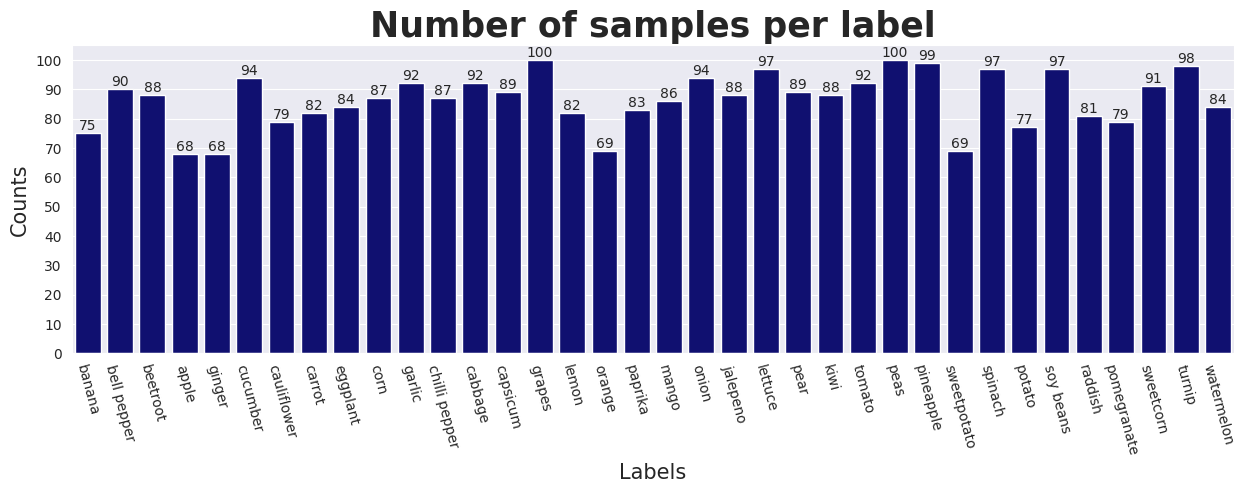

In [ ]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Número de amostras por rótulo', fontsize=25, fontweight='bold')
plt.xlabel('Rótulo', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 105, 10))
plt.show()

## <a id='step23'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 2.3 - Converter para DataFrame

In [ ]:
# Função pra retornar o DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [ ]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [ ]:
print(colored(f'Número de amostras no train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Número de amostras no validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Número de amostras no test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 3115
Number of samples in validation : 351
Number of samples test : 359


## <a id='step24'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 2.4 - <b></span><span style="color:#368F8B"><b>Mostrar uma imagem por classe</b></span></span>

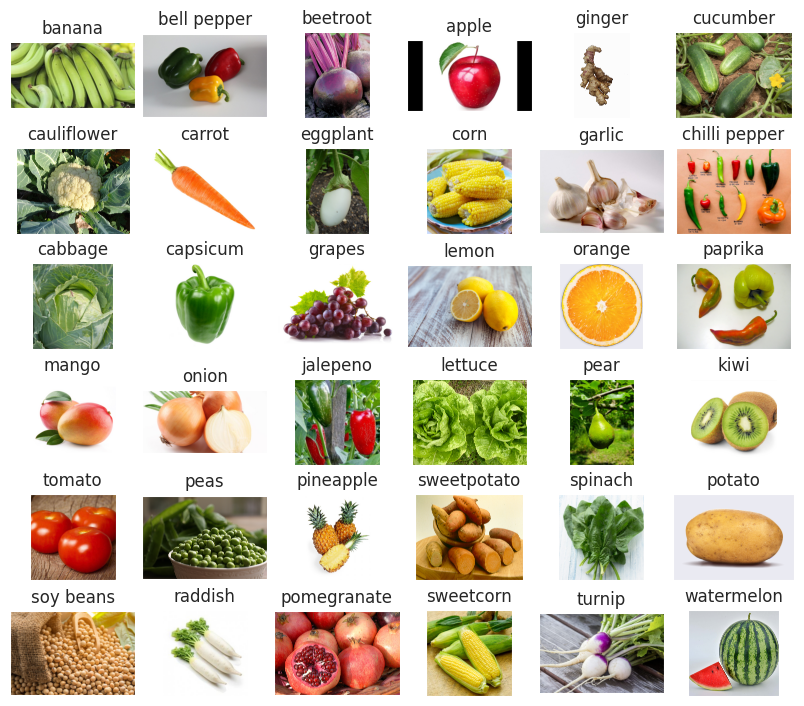

In [ ]:
# Criar um DataFrame com legenda pra cada categoria
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

## <a id='step25'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 2.5

Devido à menor quantidade de amostras em cada categoria, usamos gerador de dados e aumento de dados para evitar overfitting e alcançar melhor desempenho.

In [ ]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    rotation_range=20,              # Rorate images by factor 20 degree
    width_shift_range=0.2,          # Shift images horizontally by up to 20% of their width
    height_shift_range=0.2,         # Shift images vertically by up to 20% of their width
    zoom_range=0.1,                 # Zoom in and out images by 10%
    horizontal_flip=True,           # Allow horizontal flipping
    shear_range=0.1,                # shear images by 10% their size
    fill_mode='nearest',            # fill unlocated pixels by nearest pixel
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 3115 validated image filenames belonging to 36 classes.


In [ ]:
# validar

validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 351 validated image filenames belonging to 36 classes.


In [ ]:
# Testar

test_datagen = ImageDataGenerator(rescale=1./255,)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 359 validated image filenames belonging to 36 classes.


# <a id='step3'></a>
# <div style="background-color:#012622;background-size: cover;font-family:tahoma;font-size:200%;text-align:center;border-radius:25px 25px 25px 25px; padding:10px; border:solid 2px #09375b"><span style="color:red"><b> 3 - Modeling

## <a id='step31'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.1 - <b></span><span style="color:#368F8B"><b>Adicionar o modelo MobileNetV2</b></span></span>

In [ ]:
pre_trained_model = MobileNetV2(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## <a id='step32'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.2

In [ ]:
# Name of layers in MobileNetV2
for layer in pre_trained_model.layers :
    print(layer.name)

In [ ]:
pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

## <a id='step33'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.3 - <b></span><span style="color:#368F8B"><b>Definir um modelo</b></span></span>

In [ ]:
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))

## <a id='step34'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.4 - <b></span><span style="color:#368F8B"><b>Diagrama Modelo</b></span></span>

In [ ]:
model = models.Sequential()
model.add(pre_trained_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(36, activation='softmax'))


model.build(input_shape=(None, 224, 224, 3))

plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 1280)                │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │         327,936 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 36)                  │           4,644 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,623,460 (10.01 MB)

 Trainable params: 1,251,556 (4.77 MB)

 Non-trainable params: 1,371,904 (5.23 MB)

## <a id='step35'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.5 - <b></span><span style="color:#368F8B"><b>Compilar o Modelo</b></span></span>

In [ ]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

## <a id='step36'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.6 - <b></span><span style="color:#368F8B"><b>CallBacks</b></span></span>

In [ ]:
checkpoint_cb = ModelCheckpoint('MyModel.keras', save_best_only=True)

earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

## <a id='step37'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.7 - <b></span><span style="color:#368F8B"><b>Treinar o modelo</b></span></span>

In [ ]:
# Verificar o número de amostras no validation_generator
print(len(validation_generator))

11


In [ ]:
images, labels = next(iter(validation_generator))
print(images.shape, labels.shape)  # Verifique se as formas estão corretas


(32, 224, 224, 3) (32, 36)


In [ ]:
# Verifique se o gerador de validação retorna amostras corretamente
batch = next(iter(validation_generator))
print(batch)

In [ ]:
print(f'Número de amostras no validation_generator: {validation_generator.samples}')


Número de amostras no validation_generator: 351


In [ ]:
validation_steps = len(validation_generator)


In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=None,  # Deixe Keras calcular
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)


## <a id='step38'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.8 - <b></span><span style="color:#368F8B"><b>Resultado do treino</b></span></span>

In [ ]:
result_df = pd.DataFrame(history.history)
result_df.tail()

In [ ]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.lr, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

## <a id='step39'></a>
# <span style="font-family:tahoma;font-size:100%;text-align:left"><span style="color:red"><b> 3.9  <b></span><span style="color:#368F8B"><b>Avaliar o Modelo</b></span></span>

In [ ]:
best_model = models.load_model('MyModel.keras')

In [ ]:
test_loss, test_acc = best_model.evaluate_generator(test_generator)

print(colored(f'Test Loss : {round(test_loss, 3)}', 'green', attrs=['bold']))
print(colored(f'Test Accuracy : {round(test_acc, 3)}', 'green', attrs=['bold']))

In [ ]:
def evaluate_model_performance(model, val_generator, class_labels):
    """
    Evaluate the model's performance on the validation set and print the classification report.

    Parameters:
    - model: The trained model.
    - val_generator: Validation data generator.
    - class_labels: List of class names.

    Returns:
    - report: Classification report as a string.
    """

    true_labels = val_generator.classes

    class_labels = list(val_generator.class_indices.keys())


    predictions = model.predict(val_generator, steps=len(val_generator))


    predicted_labels = np.argmax(predictions, axis=1)


    true_labels = val_generator.classes


    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')


    colors = ["white", "#102C42"]



    cm = confusion_matrix(true_labels, predicted_labels)


    plt.figure(figsize=(15,10))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_labels, yticklabels=class_labels, cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [ ]:
evaluate_model_performance(best_model, validation_generator, classes)